In [30]:
#libraries
import numpy as np 
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from PIL import Image
import math
# imports
import os, sys

# third party imports
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler,random_split
from torchsummary import summary
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
folder_path = "/content/drive/MyDrive/final_project_data/CNN_train/"

# Define the root folder path
root_folder = folder_path

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# Create the ImageFolder dataset
dataset = ImageFolder(root=root_folder, transform=transform)

# Define the indices to split the dataset into train and test sets
test_size = 500
train_size = len(dataset)-test_size
test_data, train_data = random_split(dataset, [test_size, train_size])

# Create the DataLoaders
batch_size = 32
forShow = DataLoader(dataset,batch_size=1,shuffle=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [40]:
left = None
back = None
back_index = 0
left_index = 1
# Iterate over the dataloader to get the images and labels
for images, labels in forShow:
    image = images[0]  # Extract the image (assuming batch size is 1)
    label = labels[0]  # Extract the label (assuming batch size is 1)

    # Perform further processing with the image and label
    print(image.shape)
    print(label)
    image = image.permute(1,2,0)
    if label == 0:
      back = image
    else:
      left = image
    if left is not None and back is not None:
      break

torch.Size([3, 256, 256])
tensor(1)
torch.Size([3, 256, 256])
tensor(1)
torch.Size([3, 256, 256])
tensor(1)
torch.Size([3, 256, 256])
tensor(1)
torch.Size([3, 256, 256])
tensor(1)
torch.Size([3, 256, 256])
tensor(1)
torch.Size([3, 256, 256])
tensor(0)


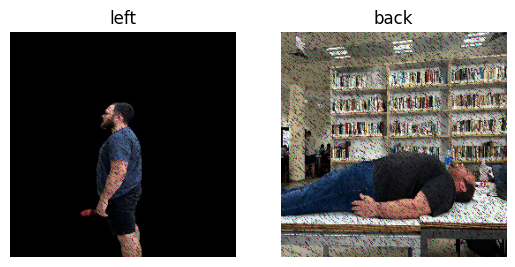

In [41]:
fig,axs = plt.subplots(1,2)

axs[0].imshow(left)
axs[0].axis('off')
axs[0].set_title('left')
axs[1].imshow(back)
axs[1].axis('off')
axs[1].set_title('back')
plt.show()

In [42]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [43]:
import torch
import torch.nn as nn

class PostureNet(nn.Module):
    def __init__(self):
        super(PostureNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * (256 // 4) * (256 // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x


In [44]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [45]:
def train(model, train_loader, optimizer, num_epochs):
    losses = []
    # Check if GPU is available
    total_start = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Training on", device)
    
    # Move the model to the GPU
    model = model.to(device)
    
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    counter = 0
    for epoch in range(num_epochs):
        running_loss = 0.0

        counter = 0;
        for images, labels in train_loader:
            if counter % 10 == 0:
              timer = time.time()
              elapsed = timer - total_start
              minutes = int(elapsed // 60)
              seconds = int(elapsed % 60)

            # Move inputs and labels to the GPU
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            counter += train_loader.batch_size
            if counter % 160 == 0:
              print(f"finished {counter}/{len(train_loader)*train_loader.batch_size} batches, ({timeSince(total_start)})")
        
        # Print data on epoch
        print('%d %d%% (%s) %.4f' % (epoch+1, (epoch+1) / num_epochs * 100, timeSince(total_start), running_loss / len(train_loader)))
        losses.append(running_loss / len(train_loader))
    return losses


In [53]:
model = PostureNet()
learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum)
num_epochs = 10

In [54]:
losses = train(model,train_loader,optimizer,num_epochs)

Training on cuda
finished 160/2112 batches, (0m 1s)
finished 320/2112 batches, (0m 4s)
finished 480/2112 batches, (0m 6s)
finished 640/2112 batches, (0m 8s)
finished 800/2112 batches, (0m 9s)
finished 960/2112 batches, (0m 10s)
finished 1120/2112 batches, (0m 12s)
finished 1280/2112 batches, (0m 14s)
finished 1440/2112 batches, (0m 16s)
finished 1600/2112 batches, (0m 18s)
finished 1760/2112 batches, (0m 20s)
finished 1920/2112 batches, (0m 22s)
finished 2080/2112 batches, (0m 25s)
1 10% (0m 25s) 0.6032
finished 160/2112 batches, (0m 28s)
finished 320/2112 batches, (0m 30s)
finished 480/2112 batches, (0m 32s)
finished 640/2112 batches, (0m 34s)
finished 800/2112 batches, (0m 36s)
finished 960/2112 batches, (0m 37s)
finished 1120/2112 batches, (0m 39s)
finished 1280/2112 batches, (0m 41s)
finished 1440/2112 batches, (0m 43s)
finished 1600/2112 batches, (0m 45s)
finished 1760/2112 batches, (0m 47s)
finished 1920/2112 batches, (0m 49s)
finished 2080/2112 batches, (0m 50s)
2 20% (0m 50s) 0

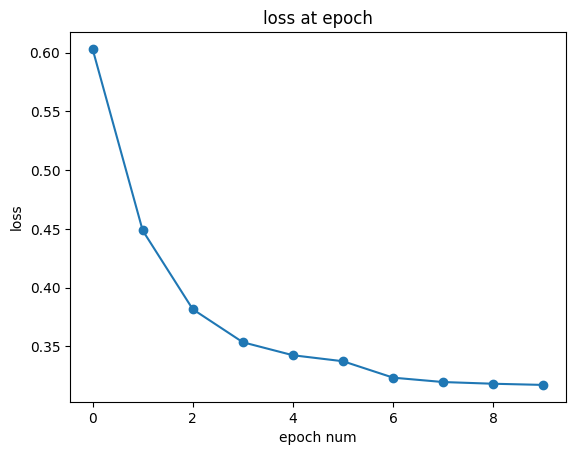

In [58]:
x = range(0,10)
plt.plot(x,losses,marker='o')
# Adding labels and title
plt.xlabel('epoch num')
plt.ylabel('loss')
plt.title('loss at epoch')

# Display the plot
plt.show()

In [55]:
def test(model, test_loader):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Testing on", device)

    # Set the model to the GPU
    model = model.to(device)

    # Lists to store predictions and labels
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs, dim=1)

            # Move predicted labels to the CPU
            predicted = predicted.cpu()

            # Collect predictions and labels
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Move labels back to CPU for metric calculation
    all_labels = torch.tensor(all_labels).cpu()

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)
    # Create a heatmap from the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues',fmt='g')

    # Adding labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


Testing on cuda
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[260   0]
 [  0 240]]


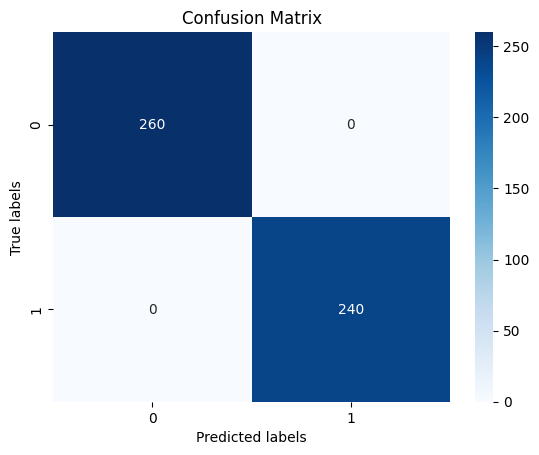

In [56]:
test(model,test_loader)

In [104]:
torch.save(model, '/content/drive/MyDrive/final_project_data/posture_cnn.pth')


In [105]:
!ls drive/MyDrive/final_project_data/

CNN_train  data_before_back  Data_before_left  Posture	posture_cnn.pth


In [62]:
model = model.to("cpu")

Predicted Labels: tensor(0)
Softmax Probabilities: tensor([0.7298, 0.2702], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(1)
Softmax Probabilities: tensor([0.2692, 0.7308], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(0)
Softmax Probabilities: tensor([0.7304, 0.2696], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(1)
Softmax Probabilities: tensor([0.2689, 0.7311], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(1)
Softmax Probabilities: tensor([0.2693, 0.7307], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(0)
Softmax Probabilities: tensor([0.7311, 0.2689], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(1)
Softmax Probabilities: tensor([0.2713, 0.7287], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(1)
Softmax Probabilities: tensor([0.2693, 0.7307], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(0)
Softmax Probabilities: tensor([0.7311, 0.2689], grad_fn=<SelectBackward0>)
Predicted Labels: tensor(0)
Softmax Probabilities: tensor([0.7276, 0.2724

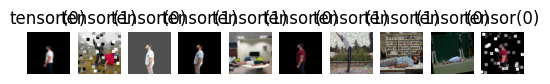

In [76]:
fig,axs = plt.subplots(1,10)
for i in range(10):

  outputs = model(image)
  # Get the predicted class labels
  _, predicted = torch.max(outputs, 1)

  # Get the softmax probabilities
  probabilities = torch.softmax(outputs, dim=1)


  image,labal = next(iter(forShow))
  row = i//5
  col = i%5
  axs[i].imshow(image.squeeze().permute(1,2,0))
  axs[i].axis('off')
  axs[i].set_title(predicted[0].squeeze())

  # Print the results
  print("Predicted Labels:", predicted[0])
  print("Softmax Probabilities:", probabilities[0])
plt.show()

In [98]:
# Define the function to plot the images
def plot_images(images, labels, predictions, probabilities):
    num_images = len(images)
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    fig.tight_layout()

    for i in range(num_images):
        row = i // 5
        col = i % 5
        image = images[i].permute(1, 2, 0)
        axs[row, col].imshow(image)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Label: {labels[i]}\n Prediction: {predictions[i]}\n Prob: {probabilities[i]}')

    plt.show()

[0, 0, 0, 1, 0, 1, 0, 0, 1, 1]
[(0.731, 0.269), (0.7311, 0.2689), (0.7311, 0.2689), (0.2689, 0.7311), (0.731, 0.269), (0.2691, 0.7309), (0.7311, 0.2689), (0.7247, 0.2753), (0.2694, 0.7306), (0.2692, 0.7308)]
['back', 'back', 'back', 'left', 'back', 'left', 'back', 'back', 'left', 'left']
['back', 'back', 'back', 'left', 'back', 'left', 'back', 'back', 'left', 'left']
[[0.7309890389442444, 0.7309890389442444, 0.7309890389442444, 0.269010990858078, 0.7309890389442444, 0.269010990858078, 0.7309890389442444, 0.7309890389442444, 0.269010990858078, 0.269010990858078], [0.731050431728363, 0.731050431728363, 0.731050431728363, 0.2689495086669922, 0.731050431728363, 0.2689495086669922, 0.731050431728363, 0.731050431728363, 0.2689495086669922, 0.2689495086669922], [0.7310566902160645, 0.7310566902160645, 0.7310566902160645, 0.26894330978393555, 0.7310566902160645, 0.26894330978393555, 0.7310566902160645, 0.7310566902160645, 0.26894330978393555, 0.26894330978393555], [0.2689493000507355, 0.268949

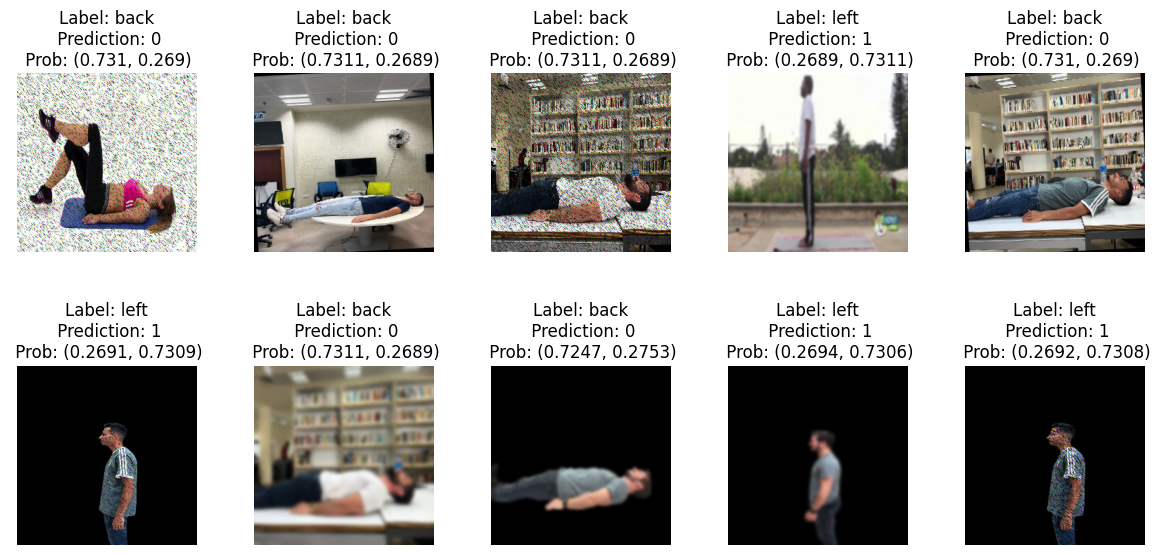

In [99]:
# Select random images from the DataLoader
random_indices = torch.randperm(len(dataset))[:10]
images = []
labels = []

# Iterate over the selected indices
for idx in random_indices:
    image, label = dataset[idx]
    images.append(image)
    labels.append(label)

# Convert the list of images to a tensor
images = torch.stack(images)

# Forward pass through the model
outputs = model(images)
probabilities = torch.softmax(outputs, dim=1)
_, predicted = torch.max(outputs, dim=1)
print(predicted.tolist())
probas = []
for i in range(len(probabilities)):
  probas.append((round(probabilities[i][0].item(),4),round(probabilities[i][1].item(),4)))
print(probas)
# Convert the tensors to Python lists
labels = [dataset.classes[label] for label in labels]
predictions = [dataset.classes[label] for label in predicted.tolist()]
probabilities = probabilities[:, predicted].tolist()
print(labels)
print(predictions)
print(probabilities)
# Plot the images with predicted labels and print the softmax probabilities
plot_images(images, labels, predicted, probas)